In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Widgets
Handle potential associated with importing widgets

In [2]:
!pip install ipywidgets --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00


## Loading and Preprocessing Data
In this section, we will load and preprocess our data using any relevant methods from `transforms` and `datasets`.
Then, we will create `DataLoader`s for our train and test sets.

If you have trouble, feel free to consult the documentation for [transforms](https://pytorch.org/vision/0.12/transforms.html) and [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10)

In [13]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,),)])
#transform = ToTensor()

In [14]:
#Loading the training set and  the data loader
training_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

#incorporate validation to boost model performance
idxs = list(range(len(training_data)))
np.random.shuffle(idxs)
#validation will be 20% of the training_dataset
split = int(np.floor(0.2 * len(training_data)))
train_sample = SubsetRandomSampler(idxs[:split])
valid_sample = SubsetRandomSampler(idxs[split:])
#validation loader and final training loader
train_loader = DataLoader(training_data, sampler=train_sample, batch_size=10)
valid_loader = DataLoader(training_data, sampler=valid_sample, batch_size=10)
#loading the test set and the data loader
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 79896441.46it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 58519658.85it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27865085.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13003773.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [15]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)

    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))

        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


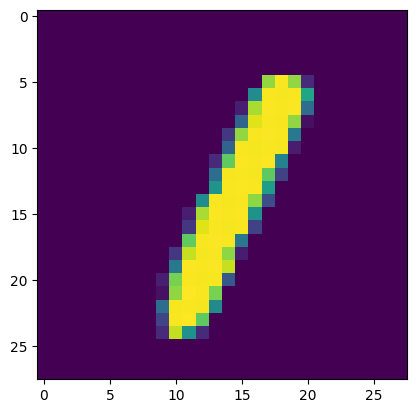

5


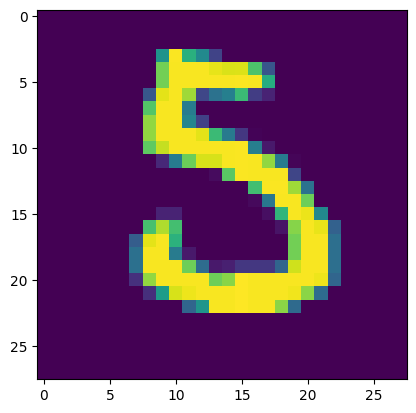

3


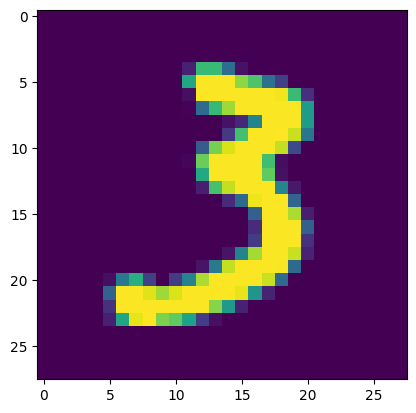

1


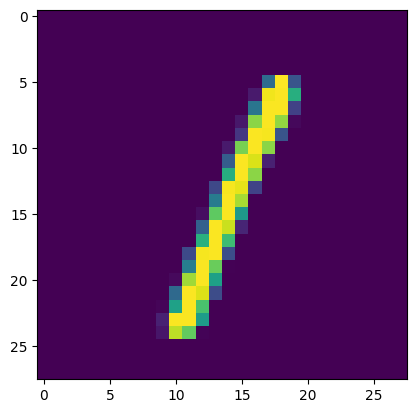

4


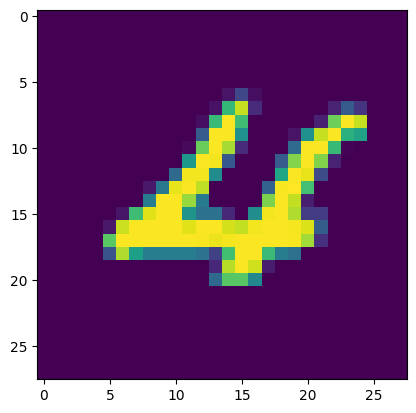

In [16]:
#explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like.

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [21]:
class MNISTClassifer(nn.Module):
    def __init__(self):
        super().__init__()
        #inputs
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        #output layer
        x = self.fc3(x)
        return x

# Instantiate the model
net = MNISTClassifer()
net.to(device)

MNISTClassifer(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

## Optimizer and Loss function
Before we get into our training loop, we need to choose an optimizer and loss function for our network.

In [25]:
model = MNISTClassifer()
# Choose an optimizer
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Choose a loss function
criterion = nn.CrossEntropyLoss()
num_epochs =15
valid_loss_min = np.Inf
steps = 0
model.train()
train_losses, valid_losses = [],[]

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch.
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [26]:
def train(valid_loss_min, model, criterion, optimizer, train_data, epochs):
  for e in range(epochs):
    running_loss = 0
    valid_loss = 0
  #model training
    for images, labels in train_data:
      optimizer.zero_grad()
      log_ps = model(images)
      loss = criterion(log_ps, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()* images.size(0)

    for images, labels in valid_loader:
      log_ps = model(images)
      loss = criterion(log_ps, labels)
      valid_loss += loss.item() * images.size(0)

    running_loss = running_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \t Training Loss {:.6f} \tValidation Loss {:6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))

    if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f}), Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'baseline_model.pt')
      valid_loss_min = valid_loss




In [27]:
train(valid_loss_min=valid_loss_min, model=model,criterion=criterion, optimizer=optimizer, train_data=train_loader, epochs=num_epochs)

Epoch: 1 	 Training Loss 1.019743 	Validation Loss 0.424839
validation loss decreased(inf), Saving Model ...
Epoch: 2 	 Training Loss 0.405831 	Validation Loss 0.363804
validation loss decreased(0.424839), Saving Model ...
Epoch: 3 	 Training Loss 0.333864 	Validation Loss 0.320428
validation loss decreased(0.363804), Saving Model ...
Epoch: 4 	 Training Loss 0.288183 	Validation Loss 0.304791
validation loss decreased(0.320428), Saving Model ...
Epoch: 5 	 Training Loss 0.253886 	Validation Loss 0.276477
validation loss decreased(0.304791), Saving Model ...
Epoch: 6 	 Training Loss 0.222893 	Validation Loss 0.233207
validation loss decreased(0.276477), Saving Model ...
Epoch: 7 	 Training Loss 0.198322 	Validation Loss 0.229510
validation loss decreased(0.233207), Saving Model ...
Epoch: 8 	 Training Loss 0.172692 	Validation Loss 0.211218
validation loss decreased(0.229510), Saving Model ...
Epoch: 9 	 Training Loss 0.158489 	Validation Loss 0.211790
Epoch: 10 	 Training Loss 0.13964

Plot the training loss (and validation loss/accuracy, if recorded).

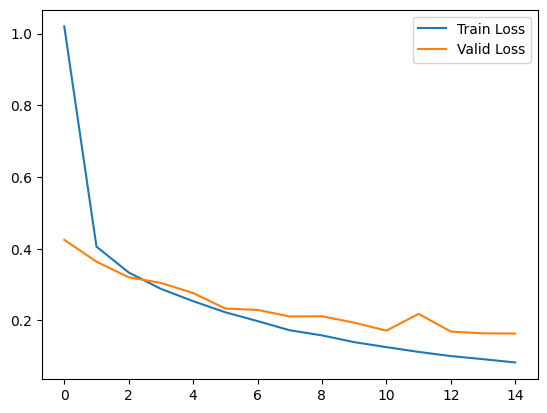

In [28]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show()



### Testing your model
Using the previously created DataLoader for the test set, compute the percentage of correct predictions using the highest probability prediction.

If your accuracy is over 90%, great work, but see if you can push a bit further! If your accuracy is under 90%, you'll need to make improvements. Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [29]:
test_loss = 0
#checking model in accuracy in the range of 10 (10 types of images of Mnist)
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))

In [30]:
def test(test_loss, class_correct, class_total, model, test_data):
  model.eval()
  for images, labels in test_loader:
    output = model(images)
    #get the loss
    loss = criterion(output, labels)
    #update test loss
    test_loss += loss.item() * images.size(0)
    #conver the probabilies of the output to the predicted class
    _, pred = torch.max(output, 1)
    #predictions vs true labels
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    #now we can track the test accuracy for each class (type of image)
    for i in range(len(labels)):
      label = labels.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
  #calcuate and track our test loss
  test_loss = test_loss / len(test_loader.sampler)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  for i in range(10):
    if class_total[i] > 0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' %
            (str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
      #handle negative values
      print('Test Accuracy of %5s: N/A (no training samples)' % class_total[i])
  #overall test accuracy
  print('\n Test Accuracy (Final): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct)/np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))


In [31]:
test(test_loss=test_loss, class_correct=class_correct, class_total=class_total, model=model, test_data=test_loader)

Test Loss: 0.152377

Test Accuracy of     0: 97% (959/980)
Test Accuracy of     1: 98% (1119/1135)
Test Accuracy of     2: 95% (988/1032)
Test Accuracy of     3: 94% (955/1010)
Test Accuracy of     4: 95% (936/982)
Test Accuracy of     5: 95% (852/892)
Test Accuracy of     6: 94% (907/958)
Test Accuracy of     7: 93% (958/1028)
Test Accuracy of     8: 94% (918/974)
Test Accuracy of     9: 94% (956/1009)

 Test Accuracy (Final): 95% (9548/10000)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

### Note
splitting the data to create a valdiation set was a prepocessing step done to boost model accuracy.
The next steps will primarily focus on hyperparameter tuning

In [36]:
#improve the model infrastructure
class MNISTClassiferTuned(nn.Module):
    def __init__(self):
        super().__init__()
        #self.activation = F.relu
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 50)
        self.relu = nn.ReLU()
        #add dropout of 20%
        self.dropout = nn.Dropout(0.20)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        #x = self.dropout(F.relu(self.fc1(x)))
        #x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        #output layer
        x = self.fc4(x)
        return x

# Instantiate the model
net = MNISTClassiferTuned()
net.to(device)

MNISTClassiferTuned(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [37]:
# Instantiate the model
net = MNISTClassiferTuned()
net.to(device)

MNISTClassiferTuned(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)

In [38]:
model = MNISTClassiferTuned()
# adjust learning rate
learning_rate = 0.03
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Choose a loss function
criterion = nn.CrossEntropyLoss()
num_epochs = 15
valid_loss_min = np.Inf
#adjust steps
steps = 2
model.train()
train_losses, valid_losses = [],[]

In [39]:
train(valid_loss_min=valid_loss_min, model=model,criterion=criterion, optimizer=optimizer, train_data=train_loader, epochs=num_epochs)

Epoch: 1 	 Training Loss 1.189690 	Validation Loss 0.668127
validation loss decreased(inf), Saving Model ...
Epoch: 2 	 Training Loss 0.516540 	Validation Loss 0.430986
validation loss decreased(0.668127), Saving Model ...
Epoch: 3 	 Training Loss 0.397577 	Validation Loss 0.356817
validation loss decreased(0.430986), Saving Model ...
Epoch: 4 	 Training Loss 0.335104 	Validation Loss 0.339624
validation loss decreased(0.356817), Saving Model ...
Epoch: 5 	 Training Loss 0.293719 	Validation Loss 0.298571
validation loss decreased(0.339624), Saving Model ...
Epoch: 6 	 Training Loss 0.254206 	Validation Loss 0.297446
validation loss decreased(0.298571), Saving Model ...
Epoch: 7 	 Training Loss 0.235650 	Validation Loss 0.283806
validation loss decreased(0.297446), Saving Model ...
Epoch: 8 	 Training Loss 0.204986 	Validation Loss 0.265579
validation loss decreased(0.283806), Saving Model ...
Epoch: 9 	 Training Loss 0.198423 	Validation Loss 0.225702
validation loss decreased(0.26557

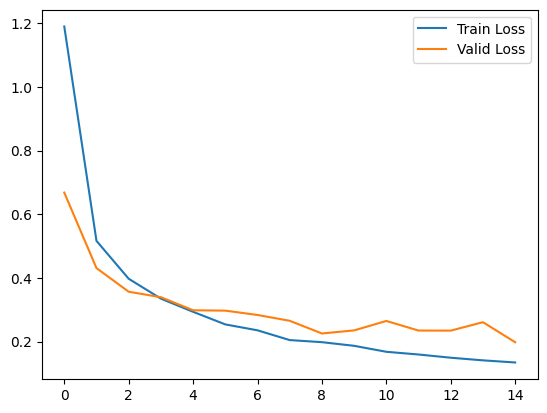

In [40]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.show()

In [41]:
test(test_loss=test_loss, class_correct=class_correct, class_total=class_total, model=model, test_data=test_loader)

Test Loss: 0.135038

Test Accuracy of     0: 98% (1927/1960)
Test Accuracy of     1: 98% (2245/2270)
Test Accuracy of     2: 95% (1977/2064)
Test Accuracy of     3: 94% (1918/2020)
Test Accuracy of     4: 96% (1890/1964)
Test Accuracy of     5: 94% (1681/1784)
Test Accuracy of     6: 95% (1836/1916)
Test Accuracy of     7: 94% (1953/2056)
Test Accuracy of     8: 94% (1846/1948)
Test Accuracy of     9: 94% (1900/2018)

 Test Accuracy (Final): 95% (19173/20000)


## Saving your model
Using `torch.save`, save your model for future loading.

In [42]:
torch.save(model.state_dict(), 'optimal_model.pt')